## TUTORIAL 05 - Discrete Empirical Interpolation Method for non-affine elliptic problems
**_Keywords: discrete empirical interpolation method_**

### 1. Introduction
In this Tutorial, we consider steady heat conduction in a two-dimensional square domain $\Omega = (-1, 1)^2$.

![mesh](data/mesh.png)

The boundary $\partial\Omega$ is kept at a reference temperature (say, zero). The conductivity coefficient is fixed to 1, while the heat source is characterized by the following expression
$$
g(\boldsymbol{x}; \boldsymbol{\mu}) = \exp\{ -2 (x_0-\mu_0)^2 - 2 (x_1 - \mu_1)^2\} \quad \forall \boldsymbol{x} = (x_0, x_1) \in \Omega.
$$

The parameter vector $\boldsymbol{\mu}$, given by 
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
affects the center of the Gaussian source $g(\boldsymbol{x}; \boldsymbol{\mu})$, which could be located at any point $\Omega$. Thus, the parameter domain is
$$
\mathbb{P}=[-1,1]^2.
$$

In order to obtain a faster evaluation (yet, provably accurate) of the problem we propose to use a certified reduced basis approximation for the problem. In order to preserve the affinity assumption (for the sake of performance) the discrete empirical interpolation method will be used on the forcing term $g(\boldsymbol{x}; \boldsymbol{\mu})$.

### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the temperature in the domain $\Omega$.

We will directly provide a weak formulation for this problem: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \left\{ v \in H^1(\Omega(\mu_0)): v|_{\partial\Omega} = 0\right\}
$$
Note that, as in the previous tutorial, the function space is parameter dependent due to the shape variation. 
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u,v;\boldsymbol{\mu}) = \int_{\Omega} \nabla u \cdot \nabla v \ d\boldsymbol{x}$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v;\boldsymbol{\mu}) = \int_\Omega g(\boldsymbol{\mu}) v  \ d\boldsymbol{x}.$$

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

## 3. Affine decomposition

The parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu})$ is trivially affine.
The discrete empirical interpolation method will be used on the forcing term $g(\boldsymbol{x}; \boldsymbol{\mu})$ to obtain an efficient (approximately affine) expansion of $f(\cdot; \boldsymbol{\mu})$.

In [2]:
@DEIM("online", basis_generation="Greedy")
@ExactParametrizedFunctions("offline")
class Gaussian(EllipticCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=subdomains)
        self.f = ParametrizedExpression(
            self, "exp(- 2 * pow(x[0] - mu[0], 2) - 2 * pow(x[1] - mu[1], 2))", mu=(0., 0.),
            element=V.ufl_element())
        # note that we cannot use self.mu in the initialization of self.f, because self.mu has not been initialized yet

    # Return custom problem name
    def name(self):
        return "GaussianDEIM"

    # Return the alpha_lower bound.
    def get_stability_factor_lower_bound(self):
        return 1.

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        if term == "a":
            return (1.,)
        elif term == "f":
            return (1.,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = inner(grad(u), grad(v)) * dx
            return (a0,)
        elif term == "f":
            f = self.f
            f0 = f * v * dx
            return (f0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 1),
                   DirichletBC(self.V, Constant(0.0), self.boundaries, 2),
                   DirichletBC(self.V, Constant(0.0), self.boundaries, 3)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/gaussian.xml")
subdomains = MeshFunction("size_t", mesh, "data/gaussian_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/gaussian_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the Gaussian class

In [5]:
problem = Gaussian(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(-1.0, 1.0), (-1.0, 1.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a reduced basis method

In [6]:
reduction_method = ReducedBasis(problem)
reduction_method.set_Nmax(20, DEIM=21)
reduction_method.set_tolerance(1e-4, DEIM=1e-8)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(100, DEIM=60)
reduced_problem = reduction_method.offline()

=                     DEIM preprocessing phase begins for                      =
=               { v_0 * f_12 } * dx(<Mesh #0>[everywhere], {}),                =
=                                    where                                     =
=       f_12 = exp(- 2 * pow(x[0] - mu_0, 2) - 2 * pow(x[1] - mu_1, 2))        =
=               with id 36f87d2cf0b6d3d52f7da4a286d52b5be3491f4c               =

:::::::::::::::::::::::::::::::::::: DEIM 0 ::::::::::::::::::::::::::::::::::::
evaluate parametrized expression at mu = (0.2840632923085755, -0.8317200700099023)
add to snapshots

:::::::::::::::::::::::::::::::::::: DEIM 1 ::::::::::::::::::::::::::::::::::::
evaluate parametrized expression at mu = (-0.6767425718107725, 0.7971083770541585)
add to snapshots

:::::::::::::::::::::::::::::::::::: DEIM 2 ::::::::::::::::::::::::::::::::::::
evaluate parametrized expression at mu = (0.21285811931917986, -0.9816058967667407)
add to snapshots

:::::::::::::::::::::::::::::::::::: DEIM 3 :::

add to snapshots

::::::::::::::::::::::::::::::::::: DEIM 42 ::::::::::::::::::::::::::::::::::::
evaluate parametrized expression at mu = (0.15656028199234795, -0.9281154524065158)
add to snapshots

::::::::::::::::::::::::::::::::::: DEIM 43 ::::::::::::::::::::::::::::::::::::
evaluate parametrized expression at mu = (-0.06880396373507969, 0.08528926941515325)
add to snapshots

::::::::::::::::::::::::::::::::::: DEIM 44 ::::::::::::::::::::::::::::::::::::
evaluate parametrized expression at mu = (-0.4269174957434312, 0.1816665211380215)
add to snapshots

::::::::::::::::::::::::::::::::::: DEIM 45 ::::::::::::::::::::::::::::::::::::
evaluate parametrized expression at mu = (-0.9389995001219011, -0.9253036225015712)
add to snapshots

::::::::::::::::::::::::::::::::::: DEIM 46 ::::::::::::::::::::::::::::::::::::
evaluate parametrized expression at mu = (0.6452011213193165, -0.2796187171774742)
add to snapshots

::::::::::::::::::::::::::::::::::: DEIM 47 ::::::::::::::::::::::::

maximum interpolation relative error = 0.44370466839935924

:::::::::::::::::::::::::::::::::: DEIM N = 7 ::::::::::::::::::::::::::::::::::
solve interpolation for mu = (0.09746757873317224, 0.3837903953853865)
compute and locate maximum interpolation error
update locations with (307,)
update basis
update interpolation matrix
interpolation error for current mu = 1.734723475976807e-18
interpolation error on interpolation locations for current mu = 2.168404344971009e-19
find next mu
maximum interpolation error = 0.0037461284583684695
maximum interpolation relative error = 0.33413811644182856

:::::::::::::::::::::::::::::::::: DEIM N = 8 ::::::::::::::::::::::::::::::::::
solve interpolation for mu = (0.9272399541785057, 0.7060189109347201)
compute and locate maximum interpolation error
update locations with (269,)
update basis
update interpolation matrix
interpolation error for current mu = 1.734723475976807e-18
interpolation error on interpolation locations for current mu = 1.73472347


find initial mu
initial maximum absolute error estimator over training set = 0.38757697328490504
initial maximum relative error estimator over training set = 1.0

#################################### N = 0 #####################################
truth solve for mu = (0.045465658763988115, -0.14491796328290074)
update basis matrix
build reduced operators
reduced order solve
build operators for error estimation
absolute error for current mu = 5.306080114615683e-16
absolute error estimator for current mu = 7.450580596923828e-09
find next mu
maximum absolute error estimator over training set = 0.17677878317707507
maximum relative error estimator over training set = 0.45611270886086996

#################################### N = 1 #####################################
truth solve for mu = (-0.5247249120152007, 0.45643269722371915)
update basis matrix
build reduced operators
reduced order solve
build operators for error estimation
absolute error for current mu = 2.718308464496755e-16
absolute e

build operators for error estimation
absolute error for current mu = 7.348384043909704e-16
absolute error estimator for current mu = 3.725290298461914e-09
find next mu
maximum absolute error estimator over training set = 0.004836368959210633
maximum relative error estimator over training set = 0.012478473419666894

#################################### N = 16 ####################################
truth solve for mu = (-0.37128803784734665, 0.01714138232940554)
update basis matrix
build reduced operators
reduced order solve
build operators for error estimation
absolute error for current mu = 9.223133416523313e-16
absolute error estimator for current mu = 1.3938759963117321e-08
find next mu
maximum absolute error estimator over training set = 0.003554486023801023
maximum relative error estimator over training set = 0.009171045414992047

#################################### N = 17 ####################################
truth solve for mu = (-0.16517799370244202, -0.5557843790585395)
update ba

#### 4.5.2 Train PINN

Given a training set $\Xi_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(N_\text{PINN})})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $u^{NN}(\boldsymbol{\mu})$ for the reduced order equations dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PINN}(\Xi_{PINN}; W) = \frac{1}{N_\text{PINN}} \sum_{i=1}^{N_\text{PINN}} \|A(\boldsymbol{\mu^{(i)}}) u^{NN}(\boldsymbol{\mu}^{(i)}; W) - \boldsymbol{f}(\boldsymbol{\mu}^{(i)})\|_2^2$$

over $W$, where for a given $\boldsymbol{\mu}$, $A(\boldsymbol{\mu})$ is the assembled reduced matrix corresponding to the bilinear form $a$ and $\boldsymbol{f}(\boldsymbol{\mu})$ is the assembled reduced vector corresponding to the linear form $f$.

In [8]:
input_normalization_pinn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pinn = Normalization.StandardNormalization()

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=40)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [9]:
pinn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
0 	Loss(training) = 0.02484890189771976 	Loss(validation) = 0.027288102213280936
100 	Loss(training) = 0.007309080750729944 	Loss(validation) = 0.008748126001268277
200 	Loss(training) = 0.0023479204659705914 	Loss(validation) = 0.0026193749992691052
300 	Loss(training) = 0.001312739265239201 	Loss(validation) = 0.001593967860119836
400 	Loss(training) = 0.0008304839372797003 	Loss(validation) = 0.0010115057791645222
500 	Loss(training) = 0.00048696565908770375 	Loss(validation) = 0.0006042051461432336
600 	Loss(training) = 0.00028431736779366024 	Loss(validation) = 0.0003685359454631539
700 	Loss(training) = 0.00018814399550246805 	Loss(validation) = 0.00025797270990120756
800 	Loss(training) = 0.00013922296825954732 	Loss(validation) = 0.00020058000676718458
900 	Loss(training) = 0.00011018028737086924 	Loss(validation) = 0.00016358269108764152
1000 	Loss(

9300 	Loss(training) = 7.997591779816219e-07 	Loss(validation) = 5.876184934382757e-06
9400 	Loss(training) = 8.809021970756025e-07 	Loss(validation) = 5.811126297310728e-06
9500 	Loss(training) = 7.449847038811767e-07 	Loss(validation) = 5.6491511584895725e-06
9600 	Loss(training) = 7.402320654605137e-07 	Loss(validation) = 5.645263440123837e-06
9700 	Loss(training) = 7.187382659427299e-07 	Loss(validation) = 5.681957137813941e-06
9800 	Loss(training) = 1.284738738208106e-06 	Loss(validation) = 5.628061603682683e-06
9900 	Loss(training) = 7.403071372985329e-07 	Loss(validation) = 5.371506602286741e-06


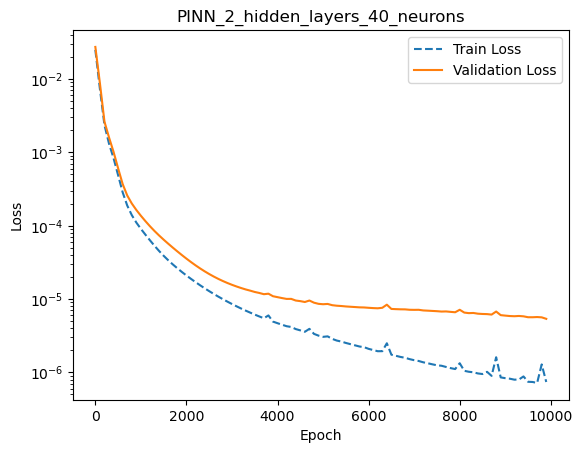

In [10]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

#### 4.5.3 Train PDNN

Given a training set $\Xi_{PDNN} = ((\boldsymbol{\mu}^{(1)}, u^{\text{HF}}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(N_\text{PDNN})}, u^{\text{HF}}(\boldsymbol{\mu}^{(N_\text{PDNN})})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(\Xi_{PDNN}; W) = \frac{1}{N_\text{PDNN}} \sum_{i=1}^{N_\text{PDNN}} \|u^{NN}(\boldsymbol{\mu}^{(i)}; W) - U^T u^{\text{HF}}(\boldsymbol{\mu}^{(i)})\|_2^2,$$
where for a given $\boldsymbol{\mu}$, the quantity $U^T u^{\text{HF}}(\boldsymbol{\mu})$ is the projection of the high fidelity solution $u^{\text{HF}}(\boldsymbol{\mu})$ onto the reduced order space.

In [11]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer, scheduler,
    input_normalization_pdnn, num_epochs=3000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [12]:
pdnn_trainer.train()

0 	Loss(training) = 1.128190636762318 	Loss(validation) = 0.3558645746611754
100 	Loss(training) = 0.7552672972787056 	Loss(validation) = 0.24610543490512252
200 	Loss(training) = 0.42816867611304976 	Loss(validation) = 0.29289701437764026
300 	Loss(training) = 0.228734795631095 	Loss(validation) = 0.4166674172916206
400 	Loss(training) = 0.10663906839818345 	Loss(validation) = 0.5123611579766456
500 	Loss(training) = 0.04538746596069056 	Loss(validation) = 0.6009648204991509
600 	Loss(training) = 0.018634388828980077 	Loss(validation) = 0.6397488836551405
700 	Loss(training) = 0.006100846506120352 	Loss(validation) = 0.660328813151577
800 	Loss(training) = 0.0014884042730556614 	Loss(validation) = 0.6737195785114984
900 	Loss(training) = 0.00032518497234913194 	Loss(validation) = 0.6824506948089054
1000 	Loss(training) = 7.075690110738197e-05 	Loss(validation) = 0.6868981548696442
1100 	Loss(training) = 1.567731583891348e-05 	Loss(validation) = 0.6889042461688994
1200 	Loss(training) 

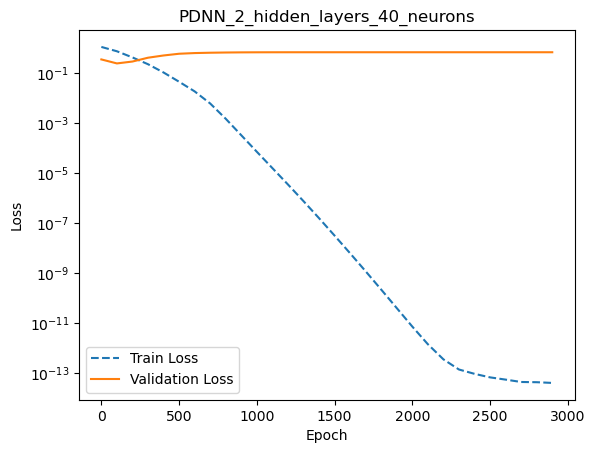

In [13]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.4 Train PRNN

We train a Physics-Reinforced Neural Network (PRNN) $N_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PRNN}(\Xi_{PINN}, \Xi_{PDNN}; W) = L_{PINN}(\Xi_{PINN}; W) + \omega L_{PDNN}(\Xi_{PDNN}; W)$$

where $\omega$ is a scaling parameter which can be chosen freely.

In [14]:
input_normalization_prnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_prnn = Normalization.StandardNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer, scheduler,
    input_normalization_prnn, num_epochs=40000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [15]:
prnn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
0 	Loss(training) = 1.1906356242485527 	Loss(validation) = 0.3499888878305306
100 	Loss(training) = 0.7260614090715266 	Loss(validation) = 0.24484621666939654
200 	Loss(training) = 0.38460395294740457 	Loss(validation) = 0.3311577492821131
300 	Loss(training) = 0.2010237880803268 	Loss(validation) = 0.4141982541711525
400 	Loss(training) = 0.09455589583908056 	Loss(validation) = 0.4494480317303082
500 	Loss(training) = 0.036940039127472506 	Loss(validation) = 0.46621757145183895
600 	Loss(training) = 0.0146519954096111 	Loss(validation) = 0.48088311685296636
700 	Loss(training) = 0.006165068889715505 	Loss(validation) = 0.4869918121091193
800 	Loss(training) = 0.0027321970304737308 	Loss(validation) = 0.49028534237330673
900 	Loss(training) = 0.0013999444795148829 	Loss(validation) = 0.4932305969856609
1000 	Loss(training) = 0.0008714590028490875 	Loss(valid

9600 	Loss(training) = 2.725976681251298e-05 	Loss(validation) = 0.40522631504870715
9700 	Loss(training) = 2.291237670906962e-05 	Loss(validation) = 0.40376135278479536
9800 	Loss(training) = 2.2712515518168286e-05 	Loss(validation) = 0.4024444142846884
9900 	Loss(training) = 2.3639880619019578e-05 	Loss(validation) = 0.4013315280566102
10000 	Loss(training) = 2.1888019426637685e-05 	Loss(validation) = 0.3997055933163654
10100 	Loss(training) = 2.1686185934498343e-05 	Loss(validation) = 0.39852924697624614
10200 	Loss(training) = 2.1216278934732396e-05 	Loss(validation) = 0.39722947484089544
10300 	Loss(training) = 2.1198052483339275e-05 	Loss(validation) = 0.3958993106300213
10400 	Loss(training) = 2.2276056255063604e-05 	Loss(validation) = 0.39446716119337133
10500 	Loss(training) = 2.0315338184556027e-05 	Loss(validation) = 0.393519015618238
10600 	Loss(training) = 2.0040685635800184e-05 	Loss(validation) = 0.39231987629564796
10700 	Loss(training) = 1.9836238871354576e-05 	Loss(va

19200 	Loss(training) = 1.2596745876731427e-05 	Loss(validation) = 0.3269167221117101
19300 	Loss(training) = 1.4347358198577448e-05 	Loss(validation) = 0.3260602434843726
19400 	Loss(training) = 1.145714585426114e-05 	Loss(validation) = 0.32569836554276793
19500 	Loss(training) = 1.1276597557079383e-05 	Loss(validation) = 0.32511775719182584
19600 	Loss(training) = 1.2320553561028373e-05 	Loss(validation) = 0.32447650806137784
19700 	Loss(training) = 1.1539007301782748e-05 	Loss(validation) = 0.3244185609987948
19800 	Loss(training) = 1.0909623529770603e-05 	Loss(validation) = 0.323788281653934
19900 	Loss(training) = 1.4458865202606224e-05 	Loss(validation) = 0.32306901612865147
20000 	Loss(training) = 1.0950700430608504e-05 	Loss(validation) = 0.3226212546659697
20100 	Loss(training) = 1.1445231332872872e-05 	Loss(validation) = 0.3220305220446069
20200 	Loss(training) = 1.0718467996135573e-05 	Loss(validation) = 0.3217325236907363
20300 	Loss(training) = 1.2414563030094183e-05 	Loss

28800 	Loss(training) = 8.622765902451185e-06 	Loss(validation) = 0.28704394710510145
28900 	Loss(training) = 1.0340230042631883e-05 	Loss(validation) = 0.286210995974105
29000 	Loss(training) = 8.179308315864124e-06 	Loss(validation) = 0.2861773506336266
29100 	Loss(training) = 9.34243143948818e-06 	Loss(validation) = 0.2857398463736437
29200 	Loss(training) = 8.305608196630612e-06 	Loss(validation) = 0.28554608742051524
29300 	Loss(training) = 8.92510386527999e-06 	Loss(validation) = 0.2850343953227917
29400 	Loss(training) = 1.127141900216246e-05 	Loss(validation) = 0.285075344441079
29500 	Loss(training) = 8.237626558852198e-06 	Loss(validation) = 0.2845328158795402
29600 	Loss(training) = 8.341341199539329e-06 	Loss(validation) = 0.2841209107653603
29700 	Loss(training) = 1.5087837627557974e-05 	Loss(validation) = 0.2838156470568763
29800 	Loss(training) = 8.159896732300441e-06 	Loss(validation) = 0.28351084158696166
29900 	Loss(training) = 8.015006536302705e-06 	Loss(validation) 

38500 	Loss(training) = 7.290108861612609e-06 	Loss(validation) = 0.2573329092023834
38600 	Loss(training) = 6.783474178403482e-06 	Loss(validation) = 0.2571106983941731
38700 	Loss(training) = 8.009796836177215e-06 	Loss(validation) = 0.2569205261446343
38800 	Loss(training) = 8.24335331306952e-06 	Loss(validation) = 0.25690635264848966
38900 	Loss(training) = 7.217487388210827e-06 	Loss(validation) = 0.25633200731974254
39000 	Loss(training) = 7.0372972332563435e-06 	Loss(validation) = 0.25601793997338457
39100 	Loss(training) = 8.002187980528506e-06 	Loss(validation) = 0.2556504165007461
39200 	Loss(training) = 7.010780871200781e-06 	Loss(validation) = 0.2555926568516054
39300 	Loss(training) = 7.047375402259419e-06 	Loss(validation) = 0.25514745032458264
39400 	Loss(training) = 7.367572075075314e-06 	Loss(validation) = 0.2550354254599848
39500 	Loss(training) = 7.09314346784057e-06 	Loss(validation) = 0.2545527743562117
39600 	Loss(training) = 7.50949638825457e-06 	Loss(validation)

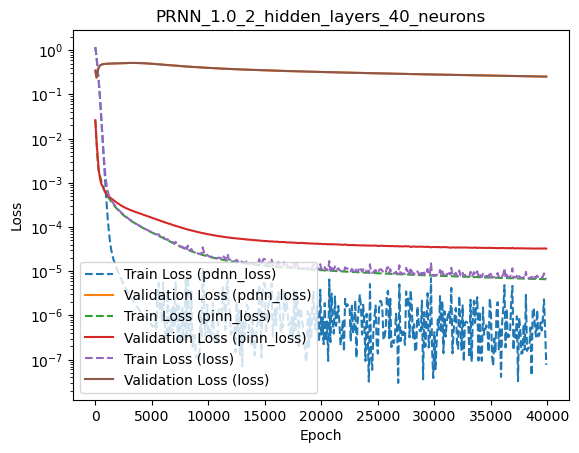

In [16]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [17]:
np.random.seed(0)

reduction_method.initialize_testing_set(100, DEIM=60)
test_set_mu = torch.tensor(reduction_method.testing_set)
online_mu = tuple(np.array(reduction_method.testing_set)[0,:])

#### 4.6.2 PINN Error Analysis

In [18]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_set_mu, input_normalization_pinn, output_normalization_pinn, relative=True
)

################################# PINN N = 20 ##################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.002819117074161443	0.0013408171889950685	0.0008175671386986706
mean	0.011656524227684562	0.007445050429800033	0.00826102706883317
max	0.10991497300918363	0.03536140933737364	0.09529484340766933


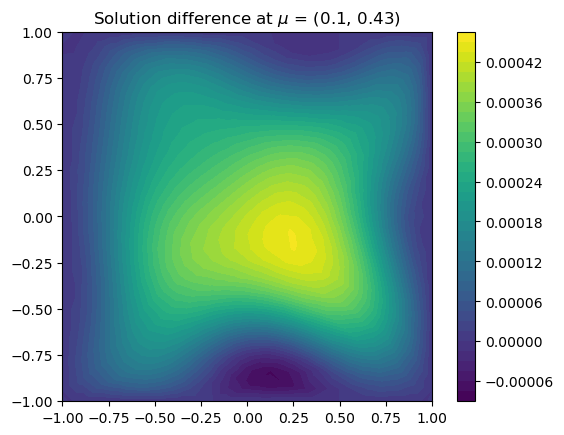

In [19]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, online_mu, input_normalization_pinn, output_normalization_pinn
)

#### 4.6.3 PDNN Error Analysis

In [20]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_set_mu, input_normalization_pdnn, output_normalization_pdnn
)

################################# PDNN N = 20 ##################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.01774680121460981	0.02023328891127178	0.0008175671386986706
mean	0.14451762199286694	0.143832501338877	0.00826102706883317
max	0.5092957328480556	0.4814487042758799	0.09529484340766933


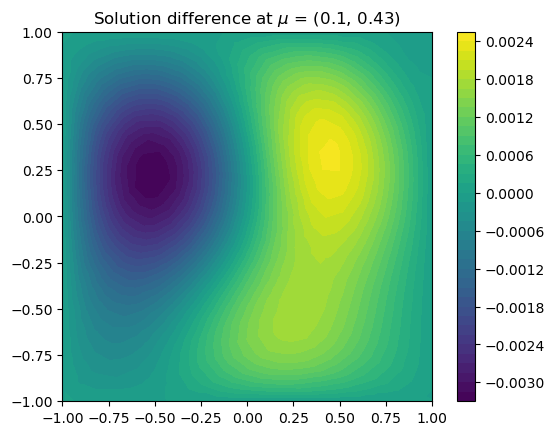

In [21]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, online_mu, input_normalization_pdnn, output_normalization_pdnn
)

#### 4.6.4 PRNN Error Analysis

In [22]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_set_mu, input_normalization_prnn, output_normalization_prnn
)

############################### PRNN_1.0 N = 20 ################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.0031908827565540632	0.004127842190211531	0.0008175671386986706
mean	0.02419090011470792	0.022821635457609755	0.00826102706883317
max	0.270501290685787	0.249012657380997	0.09529484340766933


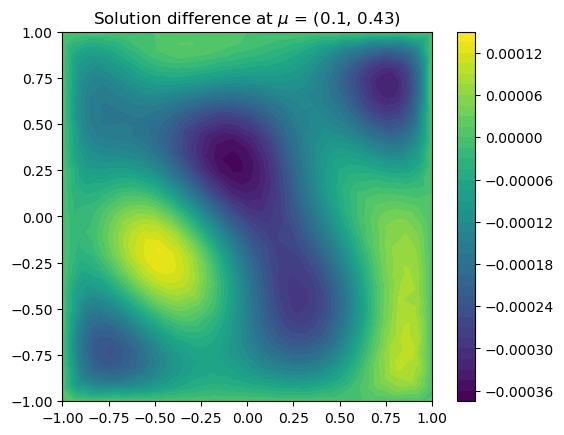

In [23]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, online_mu, input_normalization_prnn, output_normalization_prnn
)

#### 4.6.5 Neural Network Error Comparison

In [24]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_set_mu, input_normalizations, output_normalizations, euclidean=False
)

#####################################################################################
Mean Relative Error for N = 20 Basis Functions
Network		NN-HF			NN-RO			RO-HF
pinn_net	0.011656524227684562	0.007445050429800033	0.00826102706883317
pdnn_net	0.14451762199286694	0.143832501338877	0.00826102706883317
prnn_net	0.02419090011470792	0.022821635457609755	0.00826102706883317
#####################################################################################
